In [2]:
import json

with open("Conversational_Transcript_Dataset.json") as f:
    data = json.load(f)

transcripts = data["transcripts"]

In [3]:
def get_full_text(t):
    return " ".join([c["text"].lower() for c in t["conversation"]])

for t in transcripts:
    t["full_text"] = get_full_text(t)

In [4]:
def retrieve_transcript(query):
    query_words = query.lower().split()
    best_score = 0
    best_t = None

    for t in transcripts:
        score = sum(word in t["full_text"] for word in query_words)
        if score > best_score:
            best_score = score
            best_t = t

    return best_t

In [5]:
def extract_answer(query, text):
    sentences = text.split(". ")
    query_words = query.lower().split()

    matched = []
    for s in sentences:
        if any(w in s for w in query_words):
            matched.append(s.strip())

    return ". ".join(matched[:3])

In [6]:
class Memory:
    def __init__(self):
        self.tid = None
        self.text = None
        self.domain = None

memory = Memory()

In [7]:
def system_answer(query):
    # First question → retrieve
    if memory.tid is None:
        t = retrieve_transcript(query)
        memory.tid = t["transcript_id"]
        memory.text = t["full_text"]
        memory.domain = t["domain"]
    else:
        t = {"transcript_id": memory.tid,
             "full_text": memory.text,
             "domain": memory.domain}

    answer = extract_answer(query, t["full_text"])

    return {
        "Query": query,
        "Query Category": t["domain"],
        "Retrieved Call IDs": t["transcript_id"],
        "System Output": answer
    }

In [10]:
queries = [

# 1
"customer reported fraud alert and card was cancelled",

# 2
"what was the amount of the fraudulent charge",

# 3
"where did the fraudulent transaction occur",

# 4
"did the customer say they have ever been to that location",

# 5
"what did the agent do immediately after confirming fraud",

# 6
"how long will the charge reversal take",

# 7
"how many days for the new card to arrive",

# 8
"was expedited shipping mentioned",

# 9
"did the customer ask how their card information was compromised",

# 10
"what reasons did the agent give for card compromise",

# 11
"did the customer have automatic payments setup",

# 12
"what advice was given regarding automatic payments",

# 13
"did the agent offer to note recurring merchants",

# 14
"was extra security monitoring added",

# 15
"was the customer told to monitor their account",

# 16
"did the agent ask if anything else was needed",

# 17
"did the customer express satisfaction at the end",

# 18
"was the identity of the customer verified",

# 19
"what part of the card number was shared",

# 20
"what was the name of the agent",

# 21
"what department was the agent from",

# 22
"did the agent explain how fraud can happen",

# 23
"was the transaction marked as legitimate or fraudulent",

# 24
"did the agent block the card before issuing a new one",

# 25
"what shipping time was promised",

# 26
"did the agent recommend calling back if suspicious activity occurs",

# 27
"was the customer worried about anything else",

# 28
"did the agent reassure the customer",

# 29
"what tone did the agent use while handling the issue",

# 30
"was there any delay mentioned in resolving the issue",

# 31
"did the agent thank the customer",

# 32
"did the conversation end positively",

# 33
"was any follow up action promised",

# 34
"did the agent mention data breaches or phishing",

# 35
"summarize the complete resolution provided to the customer"
]

In [11]:
memory.tid = None
memory.text = None
memory.domain = None

for i, q in enumerate(queries, 1):
    res = system_answer(q)
    print(f"\nTurn {i}")
    print("Query:", res["Query"])
    print("Retrieved Call ID:", res["Retrieved Call IDs"])
    print("Output:", res["System Output"])


Turn 1
Query: customer reported fraud alert and card was cancelled
Retrieved Call ID: 3577-9057-2601-2106
Output: good afternoon, securebank customer service. how can i help you today? hi, i'm calling because i noticed some charges on my credit card that i didn't make. can you provide me with your card number? sure, it's 4532-8891-2234-5567

Turn 2
Query: what was the amount of the fraudulent charge
Retrieved Call ID: 3577-9057-2601-2106
Output: how can i help you today? hi, i'm calling because i noticed some charges on my credit card that i didn't make. which charges are you concerned about? there are two charges from yesterday - one for $120 at a restaurant in chicago and another for $350 at an electronics store. given you're not in chicago, these do appear fraudulent

Turn 3
Query: where did the fraudulent transaction occur
Retrieved Call ID: 3577-9057-2601-2106
Output: how can i help you today? hi, i'm calling because i noticed some charges on my credit card that i didn't make. wh

In [13]:
for i, q in enumerate(queries, 1):
    res = system_answer(q)

    print(f"\n========== Turn {i} ==========")
    print("Query:", res["Query"])
    print("Call ID:", res["Retrieved Call IDs"])
    # The following lines caused the KeyError as 'Memory Used' and 'Evidence Sentences' are not in the res dictionary.
    # print("Memory Used:", res["Memory Used"])
    # print("\nEvidence:")
    # for e in res["Evidence Sentences"]:
    #     print("-", e)
    print("Output:", res["System Output"])


========== Turn 1 ==========
Query: customer reported fraud alert and card was cancelled
Call ID: 3577-9057-2601-2106
Output: good afternoon, securebank customer service. how can i help you today? hi, i'm calling because i noticed some charges on my credit card that i didn't make. can you provide me with your card number? sure, it's 4532-8891-2234-5567

========== Turn 2 ==========
Query: what was the amount of the fraudulent charge
Call ID: 3577-9057-2601-2106
Output: how can i help you today? hi, i'm calling because i noticed some charges on my credit card that i didn't make. which charges are you concerned about? there are two charges from yesterday - one for $120 at a restaurant in chicago and another for $350 at an electronics store. given you're not in chicago, these do appear fraudulent

========== Turn 3 ==========
Query: where did the fraudulent transaction occur
Call ID: 3577-9057-2601-2106
Output: how can i help you today? hi, i'm calling because i noticed some charges on m

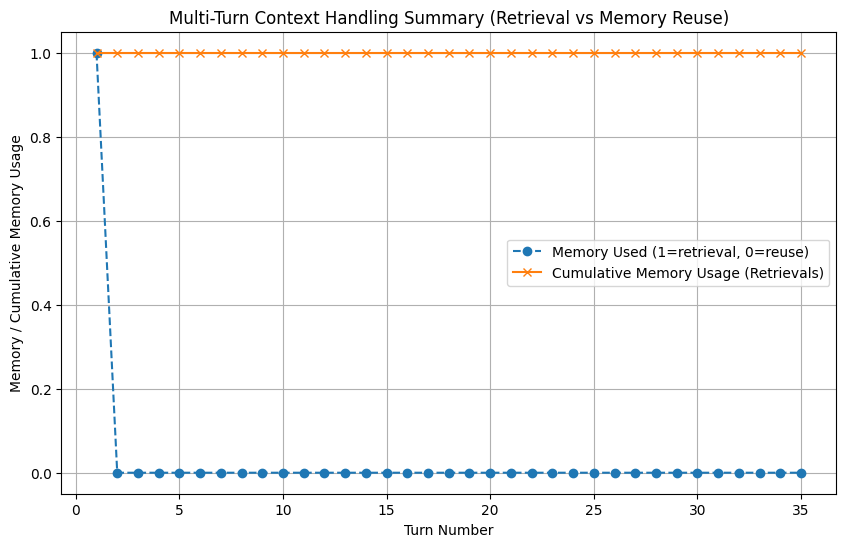

In [15]:
import matplotlib.pyplot as plt

logs = []
# Reset memory before re-running queries to accurately track new retrievals
memory.tid = None
memory.text = None
memory.domain = None

for i, q in enumerate(queries, 1):
    # Check if a new retrieval will occur in this turn
    is_new_retrieval = (memory.tid is None)
    res = system_answer(q)

    logs.append({
        "turn": i,
        "memory_used": 1 if is_new_retrieval else 0,
        "query": res["Query"],
        "call_id": res["Retrieved Call IDs"],
        "output": res["System Output"]
    })

turns = [l["turn"] for l in logs]
memory_used = [int(l["memory_used"]) for l in logs]

cumulative_memory = []
count = 0
for m in memory_used:
    count += m
    cumulative_memory.append(count)

plt.figure(figsize=(10, 6))
plt.plot(turns, memory_used, label="Memory Used (1=retrieval, 0=reuse)", marker='o', linestyle='--')
plt.plot(turns, cumulative_memory, label="Cumulative Memory Usage (Retrievals)", marker='x')
plt.xlabel("Turn Number")
plt.ylabel("Memory / Cumulative Memory Usage")
plt.title("Multi-Turn Context Handling Summary (Retrieval vs Memory Reuse)")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
logs = []

memory.tid = None
memory.text = None
memory.domain = None

for i, q in enumerate(queries, 1):
    is_new_retrieval = (memory.tid is None)
    res = system_answer(q)

    logs.append({
        "turn": i,
        "call_id": res["Retrieved Call IDs"],
        "memory_used": 1 if is_new_retrieval else 0
    })

In [19]:
logs.append({
    "turn": i,
    "call_id": res["Retrieved Call IDs"],
    "memory_used": 1 if is_new_retrieval else 0
})

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

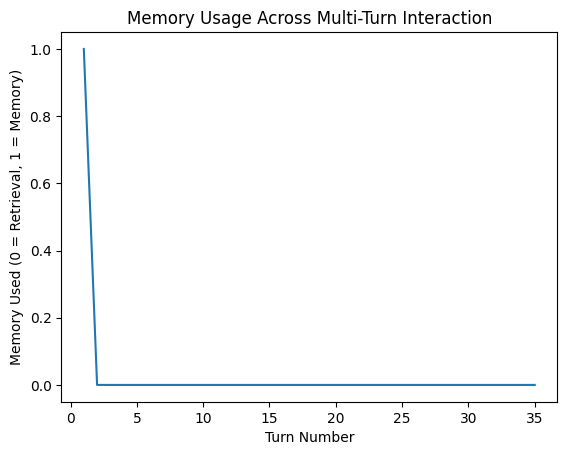

In [21]:
turns = [l["turn"] for l in logs]
memory = [int(l["memory_used"]) for l in logs]

plt.figure()
plt.plot(turns, memory)
plt.xlabel("Turn Number")
plt.ylabel("Memory Used (0 = Retrieval, 1 = Memory)")
plt.title("Memory Usage Across Multi-Turn Interaction")
plt.show()

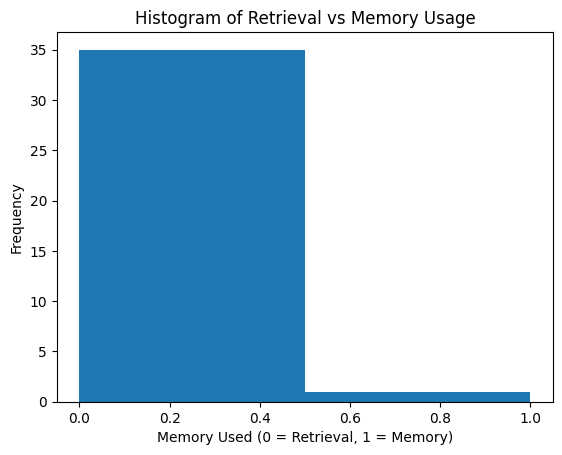

In [22]:
plt.figure()
plt.hist(memory, bins=2)
plt.xlabel("Memory Used (0 = Retrieval, 1 = Memory)")
plt.ylabel("Frequency")
plt.title("Histogram of Retrieval vs Memory Usage")
plt.show()

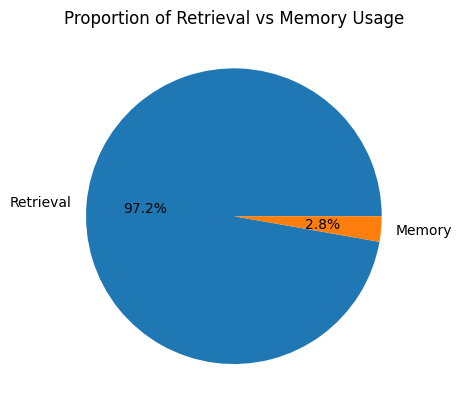

In [25]:
counts = [memory.count(0), memory.count(1)]

plt.figure()
plt.pie(counts, labels=["Retrieval", "Memory"], autopct="%1.1f%%")
plt.title("Proportion of Retrieval vs Memory Usage")
plt.show()

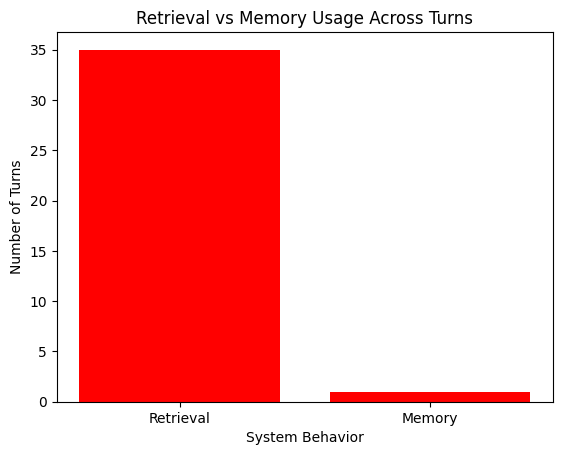

In [26]:
import matplotlib.pyplot as plt

# Extract memory usage from logs
memory = [int(l["memory_used"]) for l in logs]

retrieval_count = memory.count(0)
memory_count = memory.count(1)

labels = ["Retrieval", "Memory"]
counts = [retrieval_count, memory_count]

plt.figure()
plt.bar(labels, counts, color="red")
plt.xlabel("System Behavior")
plt.ylabel("Number of Turns")
plt.title("Retrieval vs Memory Usage Across Turns")
plt.show()